In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

from collections import deque
from sklearn.model_selection import train_test_split

import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, AveragePooling2D, Input, Concatenate, LeakyReLU, Add, Multiply
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model, Sequence
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Utils

In [2]:
# plot training history function
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 3])
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [3]:
DIR_PATH = "./RWF-2001"
TRAIN_DIR = os.path.join(DIR_PATH, "train")
TEST_DIR = os.path.join(DIR_PATH, "val")

In [4]:
CLASS_NAMES = os.listdir(TRAIN_DIR)
SEED = 1337
SEQUENCE_LENGTH  = 51
IMG_HEIGHT = 100
IMG_WIDTH = 100
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 10

ORIGINAL_FRAMES_PER_VIDEO = 150
FRAMES_PER_VIDEO = 50 + 1
VIDEO_WIDTH, VIDEO_HEIGHT = 100, 100
N_CHANNELS = 3

## Load Data

In [10]:
# get list of labels and video path
def get_labels_and_video_paths(data_dir):
    labels = []
    video_paths = []
    for label in CLASS_NAMES:
        label_dir = os.path.join(data_dir, label)
        for video in os.listdir(label_dir):
            video_paths.append(os.path.join(label_dir, video))
            labels.append(label)
    return labels, video_paths

In [11]:
import gc
from tensorflow.keras import backend as K

def load_videos(video_IDs: list, video_labels: dict, video_frames: int = FRAMES_PER_VIDEO, video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False) -> tuple:
    videos = np.empty((len(video_IDs), video_frames, video_height, video_width, video_channels), dtype=dtype)
    labels = np.empty((len(video_IDs),), dtype=np.int8)

    # Indexes of frames to be kept to comply with video_frames
    frames_idx = set(np.round(np.linspace(0, ORIGINAL_FRAMES_PER_VIDEO - 1, video_frames)).astype(int))

    for i, video_ID in enumerate(video_IDs):
        cap = cv2.VideoCapture(video_ID)
        frames = []
        index = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if index in frames_idx:
                frame = cv2.resize(frame, (video_width, video_height)).astype(dtype)
                if normalize:
                    frame /= 255.0
                frames.append(frame)
            index += 1
        cap.release()

        videos[i,] = np.array(frames)
        labels[i] = video_labels[video_ID]

    return videos, labels

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_IDs: list, video_labels: dict, batch_size: int, video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_frames: int = FRAMES_PER_VIDEO, video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False, shuffle: bool = True):
        self.video_IDs = video_IDs
        self.video_labels = video_labels
        self.batch_size = batch_size
        self.video_width = video_width
        self.video_height = video_height
        self.video_frames = video_frames
        self.video_channels = video_channels
        self.dtype = dtype
        self.normalize = normalize
        self.shuffle = shuffle

    def __len__(self):
        return len(self.video_IDs) // self.batch_size

    def __getitem__(self, idx):
        bacth_IDs = self.video_IDs[idx*self.batch_size:(idx+1)*self.batch_size]

        return load_videos(bacth_IDs, self.video_labels, self.video_frames, self.video_width, self.video_height, self.video_channels, self.dtype, self.normalize)
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.video_IDs)
        # Clear memory after epochs
        gc.collect()
        #K.clear_session()

In [12]:
import glob

train_video_IDs = glob.glob(f"{DIR_PATH}/train/*/*")
train_video_labels = {video: 0 if 'NonFight' in video else 1 for video in train_video_IDs}
test_video_IDs = glob.glob(f"{DIR_PATH}/val/*/*")
test_video_labels = {video: 0 if 'NonFight' in video else 1 for video in test_video_IDs}

train_generator = DataGenerator(train_video_IDs, train_video_labels, batch_size=10)
test_generator = DataGenerator(test_video_IDs, test_video_labels, batch_size=10)

# Training Model

In [13]:
def tf_frame_diff(video):
    return video[1:] - video[:-1]

In [20]:
import tensorflow as tf
from tensorflow.keras import layers

# Define a custom motion blur layer
class MotionBlur(layers.Layer):
    def __init__(self, kernel_size=3, **kwargs):
        super(MotionBlur, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.kernel = tf.constant([[1.0 / self.kernel_size] * self.kernel_size], dtype=tf.float32)
        self.kernel = tf.expand_dims(self.kernel, axis=-1)
        self.kernel = tf.expand_dims(self.kernel, axis=-1)
        self.kernel = tf.tile(self.kernel, [1, 1, input_shape[-1], 1])

    def call(self, inputs):
        return tf.nn.depthwise_conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME')

    def compute_output_shape(self, input_shape):
        return input_shape

# Input layer
inputs = layers.Input(shape=(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3))

# Apply Histogram Equalization
x = layers.Lambda(lambda video: tf.map_fn(lambda frame: tf.image.per_image_standardization(frame), video))(inputs)

# Add Gaussian Noise
x = layers.GaussianNoise(0.1)(x)

# Add Motion Blur
x = layers.TimeDistributed(MotionBlur(kernel_size=5))(x)

inputs_diff = layers.Lambda(lambda video: tf.map_fn(tf_frame_diff, video))(x)

# ConvLSTM2D block 1
x = layers.ConvLSTM2D(
    filters=4,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=True,
    recurrent_dropout=0.3,
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
    data_format='channels_last'
)(inputs_diff)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(x)
x = layers.TimeDistributed(layers.Dropout(0.3))(x)

# ConvLSTM2D block 2
x = layers.ConvLSTM2D(
    filters=8,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=True,
    recurrent_dropout=0.3,
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
    data_format='channels_last'
)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(x)
x = layers.TimeDistributed(layers.Dropout(0.3))(x)

# ConvLSTM2D block 3
x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=False,
    recurrent_dropout=0.3,
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
    data_format='channels_last'
)(x)
x = layers.BatchNormalization()(x)

# Depthwise Convolution
x = layers.DepthwiseConv2D(kernel_size=(3, 3), depth_multiplier=2, activation='relu', data_format='channels_last')(x)

# Global Average Pooling
x = layers.GlobalAveragePooling2D(data_format='channels_last')(x)

# Fully Connected Dense Layers
x = layers.Dense(units=128, activation='relu')(x)
x = layers.Dense(units=16, activation='relu')(x)

# Output layer
outputs = layers.Dense(units=1, activation='sigmoid')(x)

# Define and compile the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 51, 100, 100,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_6                │ (None, 51, 100, 100,   │             0 │
│ (GaussianNoise)                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 51, 100, 100,   │             0 │
│ (TimeDistributed)               │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_13 (Lambda)              │ (None, 50, 100, 100,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_18 (ConvLSTM2D)     │ (None, 50, 100, 100,   │         1,024 │
│                                 │ 4)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 50, 100, 100,   │            16 │
│ (BatchNormalization)            │ 4)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_14 (MaxPooling3D) │ (None, 50, 50, 50, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 50, 50, 50, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_19 (ConvLSTM2D)     │ (None, 50, 50, 50, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 50, 50, 50, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_15 (MaxPooling3D) │ (None, 50, 25, 25, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 50, 25, 25, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_20 (ConvLSTM2D)     │ (None, 25, 25, 16)     │        13,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 25, 25, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_4              │ (None, 11, 11, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │         4,22

 Total params: 25,137 (98.19 KB)

 Trainable params: 25,081 (97.97 KB)

 Non-trainable params: 56 (224.00 B)

In [10]:
# Add callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3)

In [11]:
EPOCH = 30

# train the model
train_hist = model.fit(train_generator,
                            validation_data = test_generator,                                    
                            epochs = EPOCH)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728457450.626755      96 service.cc:145] XLA service 0x5b97335e25c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728457450.626809      96 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728457683.495131      96 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_8', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1728457683.675895      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetim

160/160 ━━━━━━━━━━━━━━━━━━━━ 827s 4s/step - accuracy: 0.5059 - loss: 0.8384 - val_accuracy: 0.4800 - val_loss: 0.7141
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 489s 3s/step - accuracy: 0.6436 - loss: 0.6677 - val_accuracy: 0.7150 - val_loss: 0.5917
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 486s 3s/step - accuracy: 0.7646 - loss: 0.5393 - val_accuracy: 0.7675 - val_loss: 0.5046
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 486s 3s/step - accuracy: 0.7794 - loss: 0.5211 - val_accuracy: 0.7550 - val_loss: 0.5561
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 491s 3s/step - accuracy: 0.7403 - loss: 0.5522 - val_accuracy: 0.6975 - val_loss: 0.6240
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 486s 3s/step - accuracy: 0.7881 - loss: 0.5124 - val_accuracy: 0.6575 - val_loss: 0.7036
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 487s 3s/step - accuracy: 0.7632 - loss: 0.5341 - val_accuracy: 0.7725 - val_loss: 0.5134
Epoch 8/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 490s 3s/step - accuracy: 0.7927 - loss: 0.4962 - val_accuracy: 0.780

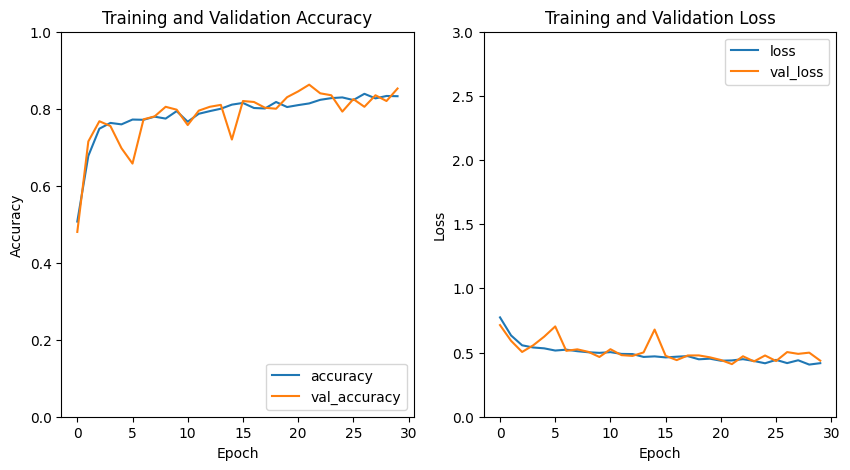

In [14]:
plot_training_history(train_hist)

In [15]:
max_val_acc = max(train_hist.history['val_accuracy'])

print(f"max val accuracy: {max_val_acc:.2f}")

max val accuracy: 0.86
